# Lab Weeks 6

Author: Dr. Amirhassan MONAJEMI. Modified by Xiao CAO


### part 1:  
#### CW1
Question1:


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a random grayscale image of size 400x400
# np.random.seed(0)
# original_image = np.random.randint(0, 256, (400, 400), dtype=np.uint8)
#In case you don't have the image

image_path='./CS4243_2023_images_small/20220511_105950gl.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Initialize an empty dictionary to store the absolute difference values
adiff_values = {}

# Loop through all interpolation algorithms
for x_center, algo in zip([0, 1, 2, 3], [cv2.INTER_NEAREST,cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]):
    # Zoom out by a factor of 0.25
    print(x_center,algo)
    zoomed_out_image = cv2.resize(original_image, None, fx=0.25, fy=0.25, interpolation=algo)
    
    # Zoom in by a factor of 4
    zoomed_in_image = cv2.resize(zoomed_out_image, (original_image.shape[1], original_image.shape[0]), interpolation=algo)
    
    # Calculate the absolute difference
    adiff = np.sum(np.abs(original_image.astype("float32") - zoomed_in_image.astype("float32")))
    
    # Store the value in the dictionary
    adiff_values[algo] = adiff

adiff_values.items()


0 0
1 1
2 2
3 3


dict_items([(0, 152499400.0), (1, 71430376.0), (2, 52420508.0), (3, 96441930.0)])

Question2:

In [2]:
import numpy as np
import cv2

def calculate_power(image):
    return np.sum(image.astype('float') ** 2) / (image.shape[0] * image.shape[1])

def calculate_entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    #cv2.calcHist(images, channels, mask, histSize, ranges)
    hist = hist.ravel() / hist.sum()
    #hist.ravel(): lattens the histogram array using ravel() to make it a one-dimensional array.
    entropy = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
    return entropy

Here, the entropy is calculated using the formula:

$$
\text{Entropy} = -\sum_{i} p(i) \log_{2}{p(i)}
$$

Where $$ p(i) $$ is the probability of occurrence of intensity value \( i \), which is what we have in the normalized histogram. The term `np.finfo(float).eps` is a very small constant added to avoid the logarithm of zero.


In [3]:

image_path_b = './CS4243_2023_images_small/20230513_190534gl.jpg'
image_path_c = './CS4243_2023_images_small/20230324_105524gl.jpg'
image_b = cv2.imread(image_path_b, cv2.IMREAD_GRAYSCALE)
image_c = cv2.imread(image_path_c, cv2.IMREAD_GRAYSCALE)

# Apply 5x5 Gaussian filter to b and c to get bGLP and cGLP
image_bGLP = cv2.GaussianBlur(image_b, (5, 5), 0)
image_cGLP = cv2.GaussianBlur(image_c, (5, 5), 0)

# Calculate power and entropy for b and bGLP
power_b = calculate_power(image_b)
power_bGLP = calculate_power(image_bGLP)
entropy_b = calculate_entropy(image_b)
entropy_bGLP = calculate_entropy(image_bGLP)

# Calculate power and entropy for c and cGLP
power_c = calculate_power(image_c)
power_cGLP = calculate_power(image_cGLP)
entropy_c = calculate_entropy(image_c)
entropy_cGLP = calculate_entropy(image_cGLP)

# Calculate percentage of power and entropy change for b
power_change_b = ((power_b - power_bGLP) / power_b) * 100
entropy_change_b = ((entropy_b - entropy_bGLP) / entropy_b) * 100

# Calculate percentage of power and entropy change for c
power_change_c = ((power_c - power_cGLP) / power_c) * 100
entropy_change_c = ((entropy_c - entropy_cGLP) / entropy_c) * 100

print('Image B: Power change: {:.2f}%, Entropy change: {:.2f}%'.format(power_change_b, entropy_change_b))
print('Image C: Power change: {:.2f}%, Entropy change: {:.2f}%'.format(power_change_c, entropy_change_c))

Image B: Power change: 3.99%, Entropy change: 0.57%
Image C: Power change: 0.15%, Entropy change: 0.54%


### Question3:

#### Butterworth Bandpass Filter Formulation

#### Objective

The objective is to create a Butterworth bandpass filter that allows frequencies within a specified range to pass through while attenuating the frequencies outside this range.

#### Parameters

- \( d_0 \) : Lower cut-off frequency
- \( d_1 \) : Upper cut-off frequency
- \( n \) : Order of the filter

#### Formulation

1. **Frequency Coordinates**: Create frequency coordinates \( u \) and \( v \) for the filter.
   
2. **Radius Calculation**: Calculate the distance \( D(u, v) \) from the origin in the frequency domain to each point \( (u, v) \).

$$
D(u, v) = \sqrt{u^2 + v^2}
$$

3. **Butterworth High-Pass Filter**: First, create a Butterworth low-pass filter $$ H_{LP}(u,v) $$ using the formula:

$$
H_{LP}(u,v) = \frac{1}{1 + \left( \frac{D(u,v)}{d_0} \right)^{2n}}
$$

4. **Convert to Low-Pass Filter**: Subtract the low-pass filter from 1.

$$
H_{HP}(u,v) = 1 - H_{LP}(u,v)
$$

5. **Apply Upper Cut-off**: Set the filter values to zero where \( D(u, v) > d_1 \).

$$
H_{HP}(u,v) = 0 \quad \text{if} \quad D(u, v) > d_1
$$

6. **Butterworth Bandpass Filter**: The final Butterworth bandpass filter \( H(u, v) \) is:

$$
H(u, v) = H_{HP}(u,v) \quad \text{if} \quad D(u, v) \leq d_1
$$




In [4]:
# Read the uploaded grayscale image 'c'
image_path_c = './CS4243_2023_images_small/IMG_0699_1024.png'
image_c = cv2.imread(image_path_c, cv2.IMREAD_GRAYSCALE)

# Function to create a Butterworth Bandpass Filter
def ButterworthBandPass(rows, cols, d0, d1, n):
    u = np.fft.fftfreq(rows)
    v = np.fft.fftfreq(cols)
    radius = np.sqrt((u[:, None]) ** 2 + (v[None, :]) ** 2)
    filter_ = 1 / (1 + (radius / d0) ** (2 * n))
    filter_ = 1 - filter_
    filter_[radius > d1] = 0
    return np.fft.fftshift(filter_)

# Compute the Fourier transform of the image
f_transform_c = np.fft.fft2(image_c)
f_transform_c = np.fft.fftshift(f_transform_c)

# Initialize an empty dictionary to store the power values
power_values = {}

# Create Butterworth Bandpass Filters and apply them
for i, (d0, d1) in enumerate([(0.05, 0.1), (0.1, 0.2), (0.2, 0.4), (0.4, 0.8)]):
    # Create Butterworth filter
    butterworth_filter = ButterworthBandPass(1024, 1024, d0, d1, 1)
    
    # Apply the filter
    filtered_f_transform = f_transform_c * butterworth_filter
    
    # Perform inverse Fourier transform
    filtered_image = np.fft.ifft2(np.fft.ifftshift(filtered_f_transform))
    
    # Calculate the power of the resulting image
    power_values[f'PcF{i}'] = calculate_power(np.abs(filtered_image))

# Sort the power_values by value
sorted_power = sorted(power_values.items(), key=lambda x: x[1], reverse=True)

sorted_power

[('PcF0', 42.97677492734777),
 ('PcF1', 38.23051963948797),
 ('PcF2', 28.550857370793327),
 ('PcF3', 10.093578546262723)]


#### Results

The calculated powers \( PcFi \) for each resulting image \( FcFi \) are as follows:

- \( PcF0 = 42.98 \)
- \( PcF1 = 38.23 \)
- \( PcF2 = 28.55 \)
- \( PcF3 = 10.09 \)




### Question4:


In [5]:
# Import required libraries
import cv2
import numpy as np

# Function to calculate power of an image
def calculate_power(image):
    return np.sum(image.astype("float32") ** 2) / (image.shape[0] * image.shape[1])

# Re-read the uploaded grayscale image 'a'
image_path_a = './CS4243_2023_images_small/IMG_20200111_141756.jpg'
image_a = cv2.imread(image_path_a, cv2.IMREAD_GRAYSCALE)

# Initialize an empty dictionary to store the power values for image 'a'
power_values_a = {}

# Function to apply Gaussian filter
def apply_gaussian_filter(image, size=(5, 5), sigma=1):
    return cv2.GaussianBlur(image, size, sigma)

# Function to apply Vertical Edge Detector filter
def apply_ved_filter(image):
    ved_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return cv2.filter2D(image, -1, ved_filter)

# Calculate the power of the original image 'a'
power_values_a['Pa'] = calculate_power(image_a)

# Apply Vertical Edge Detector filter to image 'a' and calculate its power
filtered_a_ved = apply_ved_filter(image_a)
power_values_a['Phpa'] = calculate_power(filtered_a_ved)

# Apply Gaussian filter to image 'a', then apply Vertical Edge Detector filter and calculate its power
filtered_a_gaussian = apply_gaussian_filter(image_a)
filtered_a_gaussian_ved = apply_ved_filter(filtered_a_gaussian)
power_values_a['Plphpa'] = calculate_power(filtered_a_gaussian_ved)

# Apply Gaussian filter twice to image 'a', then apply Vertical Edge Detector filter and calculate its power
filtered_a_gaussian_twice = apply_gaussian_filter(filtered_a_gaussian)
filtered_a_gaussian_twice_ved = apply_ved_filter(filtered_a_gaussian_twice)
power_values_a['Plplphpa'] = calculate_power(filtered_a_gaussian_twice_ved)

power_values_a

{'Pa': 16522.065872100473,
 'Phpa': 939.1419966679482,
 'Plphpa': 456.3208381391772,
 'Plplphpa': 287.53812636165577}

In [6]:
print(power_values_a['Plplphpa']/power_values_a['Phpa'])
print(power_values_a['Plplphpa']/power_values_a['Pa'])

0.3061710874200426
0.017403279262262174


In [7]:
# Read the uploaded grayscale image 'b'
image_path_b = './CS4243_2023_images_small/high_spat_freq.bmp'
image_b = cv2.imread(image_path_b, cv2.IMREAD_GRAYSCALE)

# Initialize an empty dictionary to store the power values for image 'b'
power_values_b = {}

# Calculate the power of the original image 'b'
power_values_b['Pb'] = calculate_power(image_b)

# Apply Vertical Edge Detector filter to image 'b' and calculate its power
filtered_b_ved = apply_ved_filter(image_b)
power_values_b['Phpb'] = calculate_power(filtered_b_ved)

# Apply Gaussian filter to image 'b', then apply Vertical Edge Detector filter and calculate its power
filtered_b_gaussian = apply_gaussian_filter(image_b)
filtered_b_gaussian_ved = apply_ved_filter(filtered_b_gaussian)
power_values_b['Plphpb'] = calculate_power(filtered_b_gaussian_ved)

# Apply Gaussian filter twice to image 'b', then apply Vertical Edge Detector filter and calculate its power
filtered_b_gaussian_twice = apply_gaussian_filter(filtered_b_gaussian)
filtered_b_gaussian_twice_ved = apply_ved_filter(filtered_b_gaussian_twice)
power_values_b['Plplphpb'] = calculate_power(filtered_b_gaussian_twice_ved)

power_values_b

{'Pb': 37922.3828125,
 'Phpb': 24450.58203125,
 'Plphpb': 9075.2822265625,
 'Plplphpb': 3629.248046875}

In [8]:
print(power_values_b['Plplphpb']/power_values_b['Phpb'])
print(power_values_b['Plplphpb']/power_values_b['Pb'])

0.14843196952270915
0.09570200440249564


----------------------------------------------------------

### Part 2: Texture Analysis

### LBP: Local Binary Patterns

1. Develop a radial P=16, R=3 LBP function
2. Try it on 
a. diag_texture.bmp 
b. hor_texture.jpg 
3. If the image is color, convert it to graylevel
4. Draw the histogram of the LBP, see the differences
5. In particular, compare the histogram of the LBPs of a and b


In [9]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
import math as m
import cv2
import numpy as np
import random as rnd
from matplotlib import pyplot as plt

img = cv2.imread('./CS4243_2023_images_small/diag_texture.bmp', 0)
img2 = cv2.imread('./CS4243_2023_images_small/hor_texture.jpg', 0)

In [11]:
def lbp_p16_r3(image, y_center, x_center):
    weights = np.array(
        [[0, 0, 2 ** 15, 1, 2, 0, 0],
         [0, 2 ** 14, 0, 0, 0, 4, 0],
         [2 ** 13, 0, 0, 0, 0, 0, 8], 
         [2 ** 12, 0, 0, 0, 0, 0, 16], 
         [2 ** 11, 0, 0, 0, 0, 0, 32],
         [0, 2 ** 10, 0, 0, 0, 64, 0],
         [0, 0, 2 ** 9, 256, 128, 0, 0]])

    thresholded_image = np.zeros([7,7])
    for i in range(7): 
        for j in range(7):
            # If pixel within 3 radius of center
            thresholded_image[i, j] = (
                image[y_center - 3 + i, x_center - 3 + j] >= image[y_center, x_center]
            )

    return np.sum(np.matmul(thresholded_image, weights))

In [12]:
height, width = img.shape

lbp_res = np.zeros((height, width))

from tqdm import tqdm # ... to show a progress bar. WHY???

# for each valid pixel in image
for i in tqdm(range(3, height - 3)): # ensure lbp does not go out of bounds
    for j in range(3, width - 3): # ensure lbp does not go out of bounds
        lbp_res[i, j] = lbp_p16_r3(img, i, j)

# resize to exclude invalid outside edge
lbp_res = lbp_res[3: height - 3, 3: width - 3]

  0%|          | 0/249 [00:00<?, ?it/s]

100%|██████████| 249/249 [00:11<00:00, 21.60it/s]


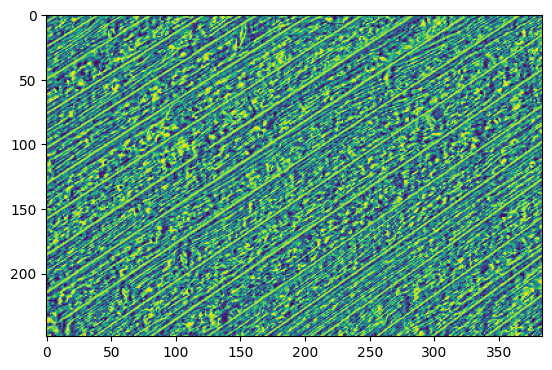

In [19]:
plt.imshow(lbp_res)

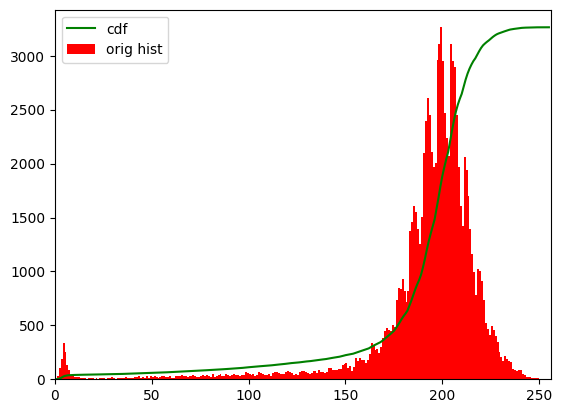

In [15]:
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='g')
plt.hist(img.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.legend(('cdf','orig hist'), loc='upper left')
plt.show()

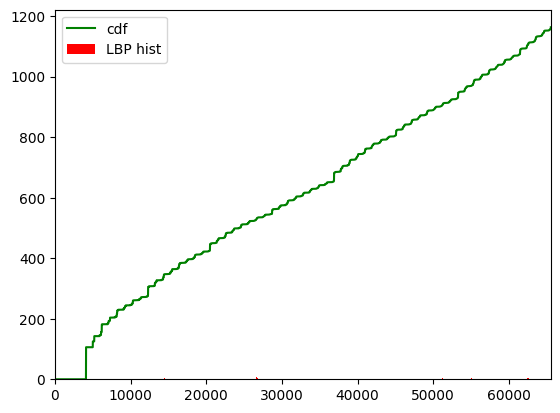

In [20]:
# LBP histogram 
hist, bins = np.histogram(lbp_res.flatten(), 2 ** 16, [0, 2 ** 16])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='g')
plt.hist(lbp_res.flatten(), 2 ** 16, [0, 2 ** 16], color='r')
plt.xlim([0, 2 ** 16])
plt.legend(('cdf', 'LBP hist'), loc='upper left')
plt.show()

In [22]:
height, width = img2.shape

lbp_res = np.zeros((height, width))

from tqdm import tqdm # ... to show a progress bar. WHY???

# for each valid pixel in image
for i in tqdm(range(3, height - 3)): # ensure lbp does not go out of bounds
    for j in range(3, width - 3): # ensure lbp does not go out of bounds
        lbp_res[i, j] = lbp_p16_r3(img2, i, j)

# resize to exclude invalid outside edge
lbp_res = lbp_res[3: height - 3, 3: width - 3]

100%|██████████| 1074/1074 [02:33<00:00,  6.98it/s]


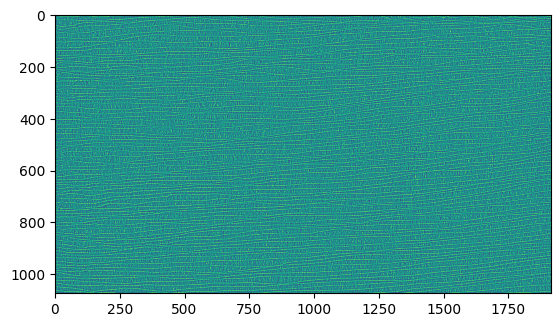

In [23]:
plt.imshow(lbp_res)

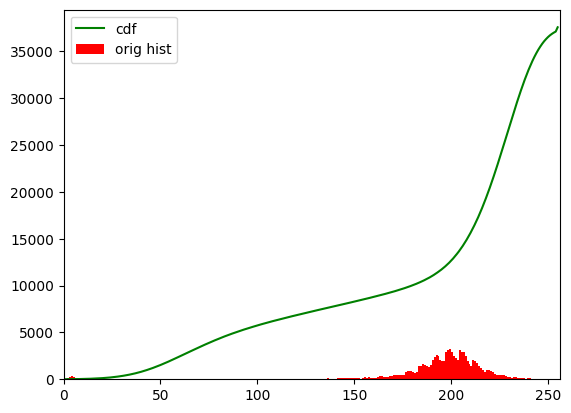

In [24]:
hist, bins = np.histogram(img2.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='g')
plt.hist(img.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.legend(('cdf','orig hist'), loc='upper left')
plt.show()

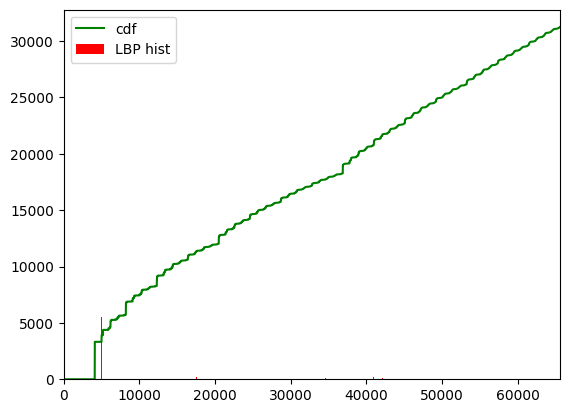

In [25]:
# LBP histogram 
hist, bins = np.histogram(lbp_res.flatten(), 2 ** 16, [0, 2 ** 16])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='g')
plt.hist(lbp_res.flatten(), 2 ** 16, [0, 2 ** 16], color='r')
plt.xlim([0, 2 ** 16])
plt.legend(('cdf', 'LBP hist'), loc='upper left')
plt.show()